In [1]:
from splice.nonalternating_baseline import DCCA, Karakasis, DCCAE
import numpy as np

import matplotlib.pyplot as plt
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import math
import torch.nn.functional as F
import pickle
import os

from sklearn.linear_model import LinearRegression

from copy import deepcopy

In [2]:
with open(
        "../data/lgn-v1/random_18.9k/random_18.9k_train.pkl",
        "rb",
    ) as f:
        train_data = pickle.load(f)

a_train = torch.Tensor(train_data["responses"]["lgn"][:12096]).to(device)
b_train = torch.Tensor(train_data["responses"]["v1"][:12096]).to(device)

a_validation = torch.Tensor(train_data["responses"]["lgn"][12096:]).to(device)
b_validation = torch.Tensor(train_data["responses"]["v1"][12096:]).to(device)

with open(
        "../data/lgn-v1/random_18.9k/random_18.9k_test.pkl",
        "rb",
    ) as f:
        test_data = pickle.load(f)

a_test = torch.Tensor(test_data["responses"]["lgn"]).to(device)
b_test = torch.Tensor(test_data["responses"]["v1"]).to(device)

### DCCA

In [70]:
config =  {'batch_size': 2000, 'lr': 0.001, 'n_hidden': 200, 'n_layers': 3, 'weight_decay': 0}

model = DCCA(
            n_a=400,
            n_b=800,
            z_dim=2,
            device=device,
            layers=[config["n_hidden"]] * config["n_layers"],
        ).to(device)

In [71]:
optimizer = torch.optim.AdamW(
            model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"]
        )

num_epochs = int(50000/(12096/config["batch_size"]))
batch_size = config["batch_size"]

best_loss = np.inf
best_params = None

In [72]:
model

DCCA(
  (encoder_a): encoder(
    (layers): Sequential(
      (0): Linear(in_features=400, out_features=200, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): Sigmoid()
      (4): Linear(in_features=200, out_features=200, bias=True)
      (5): Sigmoid()
      (6): Linear(in_features=200, out_features=2, bias=True)
    )
  )
  (encoder_b): encoder(
    (layers): Sequential(
      (0): Linear(in_features=800, out_features=200, bias=True)
      (1): Sigmoid()
      (2): Linear(in_features=200, out_features=200, bias=True)
      (3): Sigmoid()
      (4): Linear(in_features=200, out_features=200, bias=True)
      (5): Sigmoid()
      (6): Linear(in_features=200, out_features=2, bias=True)
    )
  )
)

In [73]:
current_loss = 1
stop = False
for epoch in range(num_epochs):
    print("EPOCH %d" %epoch, end="\r")

    for i in range(0, a_train.shape[0], batch_size):
        a_batch = a_train[i : i + batch_size]
        b_batch = b_train[i : i + batch_size]

        z_a, z_b = model(a_batch, b_batch)
        loss = model.loss(z_a, z_b)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del a_batch, b_batch, z_a, z_b

    z_val_a, z_val_b = model(a_validation, b_validation)
    loss = model.loss(z_val_a, z_val_b)

    if current_loss - loss < 1e-3:
        break

    current_loss = loss

    if loss < best_loss:
        best_loss = loss.item()
        best_params = deepcopy(model.state_dict())

    if epoch % 10 == 0:
        print("Epoch %d, Validation Loss: %.4f" % (epoch, loss.item()))

Epoch 0, Validation Loss: 0.9963
Epoch 10, Validation Loss: 0.4780
Epoch 20, Validation Loss: 0.0057


In [74]:
model.load_state_dict(best_params)
torch.save(model.state_dict(), "../results/models/lgn-v1/dcca_lgn-v1_random18.9k.pt")

In [75]:
train_z_a, train_z_b = model(a_train, b_train)
test_z_a, test_z_b = model(a_test, b_test)

train_z_a = train_z_a.detach().cpu().numpy()
train_z_b = train_z_b.detach().cpu().numpy()

test_z_a = test_z_a.detach().cpu().numpy()
test_z_b = test_z_b.detach().cpu().numpy()

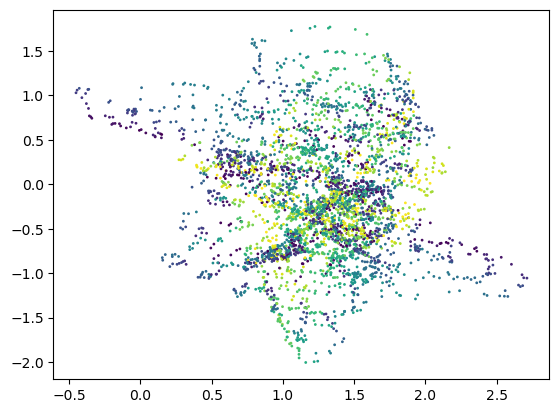

In [76]:
plt.scatter(test_z_a[:, 0], test_z_a[:, 1], s=1, c=test_data["stim_params"]["x"])

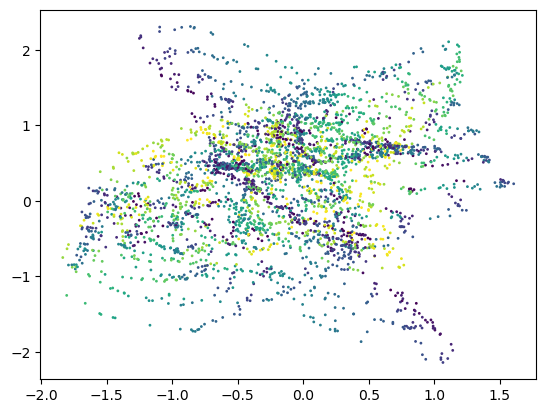

In [77]:
plt.scatter(test_z_b[:, 0], test_z_b[:, 1], s=1, c=test_data["stim_params"]["x"])

In [78]:
reg = LinearRegression().fit(train_z_a, train_data["stim_params"]["x"][:12096])
print("X decoding from shared a R^2: %.4f" % reg.score(test_z_a, test_data["stim_params"]["x"]))

reg = LinearRegression().fit(train_z_a, train_data["stim_params"]["y"][:12096])
print("Y decoding from shared a R^2: %.4f" % reg.score(test_z_a, test_data["stim_params"]["y"]))

reg = LinearRegression().fit(train_z_b, train_data["stim_params"]["x"][:12096])
print("X decoding from shared a2b R^2: %.4f" % reg.score(test_z_b, test_data["stim_params"]["x"]))

reg = LinearRegression().fit(train_z_b, train_data["stim_params"]["y"][:12096])
print("Y decoding from shared a2b R^2: %.4f" % reg.score(test_z_b, test_data["stim_params"]["y"]))

X decoding from shared a R^2: 0.0044
Y decoding from shared a R^2: 0.0143
X decoding from shared a2b R^2: 0.0052
Y decoding from shared a2b R^2: 0.0157


### DCCAE

In [79]:
config =  {'batch_size': 5000, 'lr': 0.01, 'n_hidden': 200, 'n_layers': 2, 'weight_decay': 0}

model = DCCAE(
            n_a=400,
            n_b=800,
            z_dim=2,
            device=device,
            layers=[config["n_hidden"]] * config["n_layers"],
            _lambda=0.9
        ).to(device)

In [80]:
optimizer = torch.optim.AdamW(
            model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"]
        )

num_epochs = int(50000/(12096/config["batch_size"]))
batch_size = config["batch_size"]

scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, total_iters=num_epochs, start_factor=1, end_factor=1/50)

best_loss = np.inf
best_params = None

In [82]:
# current_loss = 1
stop = False
for epoch in range(num_epochs):
    print("EPOCH %d" %epoch, end="\r")

    for i in range(0, a_train.shape[0], batch_size):
        a_batch = a_train[i : i + batch_size]
        b_batch = b_train[i : i + batch_size]

        a_hat, b_hat, z_a, z_b = model(a_batch, b_batch)
        loss, cca_loss, recon_loss_a, recon_loss_b = model.loss(
                            a_batch,
                            b_batch,
                            a_hat,
                            b_hat,
                            z_a,
                            z_b,
                        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del a_batch, b_batch, a_hat, b_hat, z_a, z_b

    scheduler.step()

    x_a_hat, x_b_hat, z_val_a, z_val_b  = model(a_validation, b_validation)
    loss, cca_loss, recon_loss_a, recon_loss_b = model.loss(
                        a_validation,
                        b_validation,
                        x_a_hat,
                        x_b_hat,
                        z_val_a,
                        z_val_b,
                    )

    # if current_loss - loss < 1e-4:
    #     break

    # current_loss = loss

    if loss < best_loss:
        best_loss = loss.item()
        best_params = deepcopy(model.state_dict())

    if epoch % 100 == 0:
        print("Epoch %d, Validation Loss: %.4f CCA Loss: %.4f Reconstruction Loss: %.4f" % (epoch, loss.item(), cca_loss.item(), recon_loss_a.item()+recon_loss_b.item()))

Epoch 0, Validation Loss: 0.1395 CCA Loss: 0.8734 Reconstruction Loss: 0.1158
Epoch 100, Validation Loss: 0.0431 CCA Loss: 0.0003 Reconstruction Loss: 0.0958
Epoch 200, Validation Loss: 0.0432 CCA Loss: 0.0005 Reconstruction Loss: 0.0958
Epoch 300, Validation Loss: 0.0431 CCA Loss: 0.0001 Reconstruction Loss: 0.0958
Epoch 400, Validation Loss: 0.0431 CCA Loss: 0.0001 Reconstruction Loss: 0.0958
Epoch 500, Validation Loss: 0.0430 CCA Loss: 0.0001 Reconstruction Loss: 0.0956
Epoch 600, Validation Loss: 0.0429 CCA Loss: 0.0001 Reconstruction Loss: 0.0954
Epoch 700, Validation Loss: 0.0429 CCA Loss: 0.0001 Reconstruction Loss: 0.0953
Epoch 800, Validation Loss: 0.0429 CCA Loss: 0.0001 Reconstruction Loss: 0.0953
Epoch 900, Validation Loss: 0.0427 CCA Loss: 0.0004 Reconstruction Loss: 0.0948
Epoch 1000, Validation Loss: 0.0426 CCA Loss: 0.0003 Reconstruction Loss: 0.0946
Epoch 1100, Validation Loss: 0.0401 CCA Loss: 0.0021 Reconstruction Loss: 0.0887
Epoch 1200, Validation Loss: 0.0358 CCA 

In [83]:
model.load_state_dict(best_params)
torch.save(model.state_dict(), "../results/models/lgn-v1/dccae_lgn-v1_random18.9k.pt")

In [84]:
_,_,train_z_a, train_z_b = model(a_train, b_train)
_,_,test_z_a, test_z_b = model(a_test, b_test)

train_z_a = train_z_a.detach().cpu().numpy()
train_z_b = train_z_b.detach().cpu().numpy()

test_z_a = test_z_a.detach().cpu().numpy()
test_z_b = test_z_b.detach().cpu().numpy()

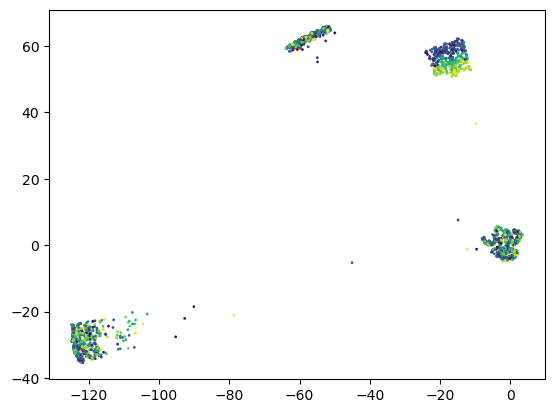

In [89]:
plt.scatter(test_z_a[:, 0], test_z_a[:, 1], s=1, c=test_data["stim_params"]["x"])

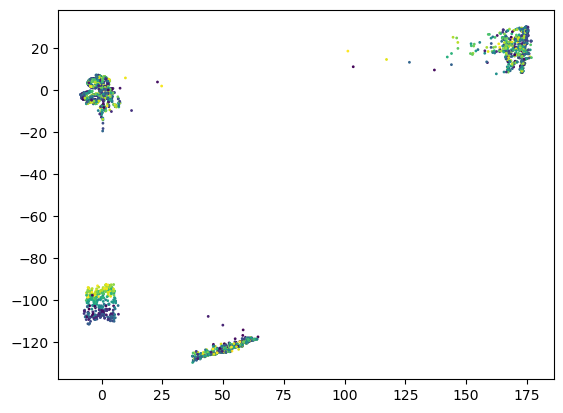

In [86]:
plt.scatter(test_z_b[:, 0], test_z_b[:, 1], s=1, c=test_data["stim_params"]["x"])

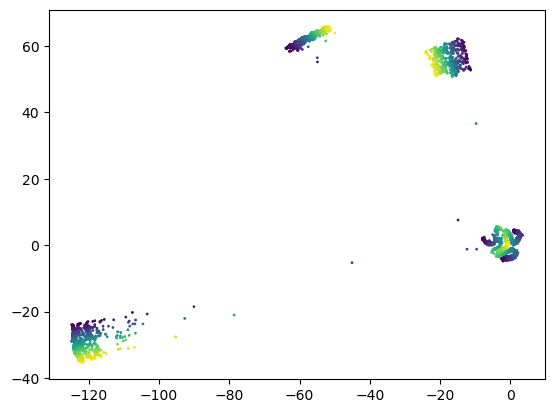

In [90]:
plt.scatter(test_z_a[:, 0], test_z_a[:, 1], s=1, c=test_data["stim_params"]["lgn_p"])

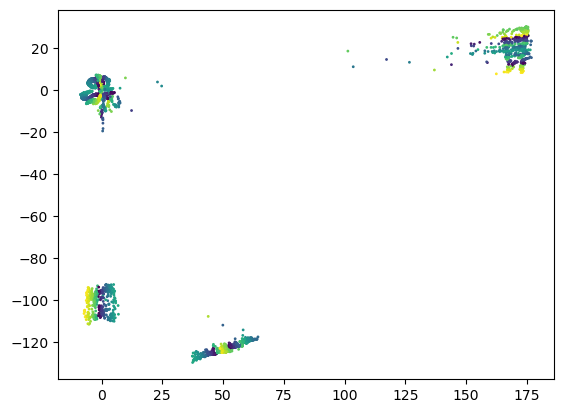

In [92]:
plt.scatter(test_z_b[:, 0], test_z_b[:, 1], s=1, c=test_data["stim_params"]["v1_p"])

In [87]:
reg = LinearRegression().fit(train_z_a, train_data["stim_params"]["x"][:12096])
print("X decoding from shared a R^2: %.4f" % reg.score(test_z_a, test_data["stim_params"]["x"]))

reg = LinearRegression().fit(train_z_a, train_data["stim_params"]["y"][:12096])
print("Y decoding from shared a R^2: %.4f" % reg.score(test_z_a, test_data["stim_params"]["y"]))

reg = LinearRegression().fit(train_z_b, train_data["stim_params"]["x"][:12096])
print("X decoding from shared a2b R^2: %.4f" % reg.score(test_z_b, test_data["stim_params"]["x"]))

reg = LinearRegression().fit(train_z_b, train_data["stim_params"]["y"][:12096])
print("Y decoding from shared a2b R^2: %.4f" % reg.score(test_z_b, test_data["stim_params"]["y"]))

X decoding from shared a R^2: -0.0003
Y decoding from shared a R^2: 0.2638
X decoding from shared a2b R^2: -0.0003
Y decoding from shared a2b R^2: 0.2551


### Karakasis

In [12]:
config =  {'batch_size': 800, 'lr': 0.001, 'n_hidden': 200, 'n_layers': 3, 'weight_decay': 0}

model = Karakasis(
            n_a=400,
            n_b=800,
            z_dim=2,
            device=device,
            layers=[config["n_hidden"]] * config["n_layers"],
            _lambda=0.9
        ).to(device)

In [13]:
optimizer = torch.optim.AdamW(
            model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"]
        )

num_epochs = int(50000/(12096/config["batch_size"]))
batch_size = config["batch_size"]

scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, total_iters=num_epochs, start_factor=1, end_factor=1/50)

best_loss = np.inf
best_params = None

In [14]:
# current_loss = 1
for epoch in range(num_epochs):
    print("EPOCH %d" %epoch, end="\r")

    for i in range(0, a_train.shape[0], batch_size):
        a_batch = a_train[i : i + batch_size]
        b_batch = b_train[i : i + batch_size]

        a_hat, b_hat, z_a, z_b = model(a_batch, b_batch)
        loss, cca_loss, recon_loss_a, recon_loss_b = model.loss(
                            a_batch,
                            b_batch,
                            a_hat,
                            b_hat,
                            z_a,
                            z_b,
                        )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del a_batch, b_batch, a_hat, b_hat, z_a, z_b

    scheduler.step()

    x_a_hat, x_b_hat, z_val_a, z_val_b  = model(a_validation, b_validation)
    loss, cca_loss, recon_loss_a, recon_loss_b = model.loss(
                        a_validation,
                        b_validation,
                        x_a_hat,
                        x_b_hat,
                        z_val_a,
                        z_val_b,
                    )

    # if current_loss - loss < 1e-4:
    #     break

    # current_loss = loss

    if loss < best_loss:
        best_loss = loss.item()
        best_params = deepcopy(model.state_dict())

    if epoch % 100 == 0:
        print("Epoch %d, Validation Loss: %.4f CCA Loss: %.4f Reconstruction Loss: %.4f" % (epoch, loss.item(), cca_loss.item(), recon_loss_a.item()+recon_loss_b.item()))

Epoch 0, Validation Loss: 0.1449 CCA Loss: 0.9932 Reconstruction Loss: 0.1014
Epoch 100, Validation Loss: 0.0419 CCA Loss: 0.0002 Reconstruction Loss: 0.0931
Epoch 200, Validation Loss: 0.0408 CCA Loss: 0.0005 Reconstruction Loss: 0.0905
Epoch 300, Validation Loss: 0.0400 CCA Loss: 0.0004 Reconstruction Loss: 0.0888
Epoch 400, Validation Loss: 0.0398 CCA Loss: 0.0005 Reconstruction Loss: 0.0884
Epoch 500, Validation Loss: 0.0399 CCA Loss: 0.0007 Reconstruction Loss: 0.0885
Epoch 600, Validation Loss: 0.0395 CCA Loss: 0.0005 Reconstruction Loss: 0.0876
Epoch 700, Validation Loss: 0.0396 CCA Loss: 0.0006 Reconstruction Loss: 0.0880
Epoch 800, Validation Loss: 0.0396 CCA Loss: 0.0006 Reconstruction Loss: 0.0878
Epoch 900, Validation Loss: 0.0396 CCA Loss: 0.0006 Reconstruction Loss: 0.0878
Epoch 1000, Validation Loss: 0.0396 CCA Loss: 0.0008 Reconstruction Loss: 0.0879
Epoch 1100, Validation Loss: 0.0397 CCA Loss: 0.0008 Reconstruction Loss: 0.0881
Epoch 1200, Validation Loss: 0.0399 CCA 

In [15]:
model.load_state_dict(best_params)
torch.save(model.state_dict(), "../results/models/lgn-v1/karakasis_lgn-v1_random18.9k.pt")

In [16]:
_,_,train_z_a, train_z_b = model(a_train, b_train)
_,_,test_z_a, test_z_b = model(a_test, b_test)

train_z_a = train_z_a.detach().cpu().numpy()
train_z_b = train_z_b.detach().cpu().numpy()

test_z_a = test_z_a.detach().cpu().numpy()
test_z_b = test_z_b.detach().cpu().numpy()

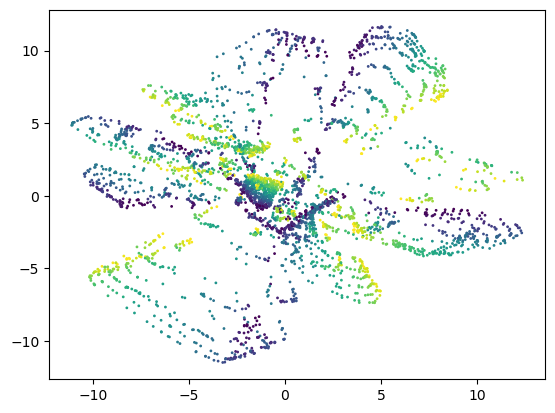

In [17]:
plt.scatter(test_z_a[:, 0], test_z_a[:, 1], s=1, c=test_data["stim_params"]["x"])

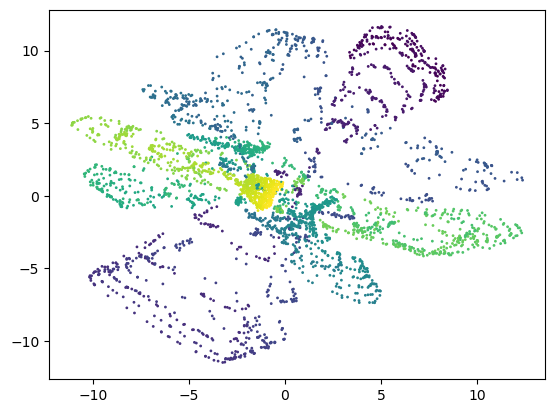

In [18]:
plt.scatter(test_z_a[:, 0], test_z_a[:, 1], s=1, c=test_data["stim_params"]["y"])

In [19]:
reg = LinearRegression().fit(train_z_a, train_data["stim_params"]["x"][:12096])
print("X decoding from shared a R^2: %.4f" % reg.score(test_z_a, test_data["stim_params"]["x"]))

reg = LinearRegression().fit(train_z_a, train_data["stim_params"]["y"][:12096])
print("Y decoding from shared a R^2: %.4f" % reg.score(test_z_a, test_data["stim_params"]["y"]))

reg = LinearRegression().fit(train_z_b, train_data["stim_params"]["x"][:12096])
print("X decoding from shared a2b R^2: %.4f" % reg.score(test_z_b, test_data["stim_params"]["x"]))

reg = LinearRegression().fit(train_z_b, train_data["stim_params"]["y"][:12096])
print("Y decoding from shared a2b R^2: %.4f" % reg.score(test_z_b, test_data["stim_params"]["y"]))

X decoding from shared a R^2: 0.0003
Y decoding from shared a R^2: 0.0534
X decoding from shared a2b R^2: 0.0003
Y decoding from shared a2b R^2: 0.0527
